##### Generate files containing all genic and intergenic regions in reference organism

In [117]:
import pandas as pd
pd.options.mode.chained_assignment = None  
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import time
from tqdm.auto import tqdm
import random
import copy
from joblib import Parallel, delayed
import os
import shutil
import subprocess
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Align.Applications import MuscleCommandline
import re
import shutil
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Blast_Functions as blastfn
from scipy.stats import chi2
from IPython import display
num_cores = 16
core_numbers = list(range(1, num_cores+1))

project_dir = 'D:/Project_Data/Project_8'
output_dir = project_dir + '/Test'
datasets_dir = project_dir + '/Datasets'
seq_dir = datasets_dir + '/Actinobacteria_Ref_Rep_Lev_Complete'

reference_species = 'NZ_CP102342.1'
tb_species = 'NC_000962.3' 

##### Parameters for run - Produce data builds dictionaries, etc.   Search region = 'U' Upstream 'D' Downstream.   Use Near Region searches 500 nt up/down of homologous hits.  Use Mycobrowser uses mycobrowser to define inter-feature regions

In [201]:
produce_data = False
use_near_regions_only = True
search_region = 'U'
use_mycobrowser = False

#####  Functions and classes 

In [17]:
class Translator:
    def __init__(self):
        self.codon_dict = {}
        with open(datasets_dir + '/Standard_Code.txt', 'r') as f:
       	    for l in f:
                self.codon_dict[str(l[1:4])] = l[5]
    
    def reverse_complement(self, seq_string):
        complement_dict = {'A':'T','C':'G','G':'C','T':'A','N':'N'}
        temp = []
        for char in reversed(seq_string):
            if char in complement_dict:
                temp.append(complement_dict[char])
        else:
                temp.append('A')
        return ''.join(temp)
    
    def translate_sequence(self, input_seq, strand, rf, separate_start_symbol = False, separate_stop_symbol = False):
        output_seq = ''
        if strand == 1:
            seq = input_seq[rf:]
        else:
            seq = self.reverse_complement(input_seq)[rf:]
        for i in range(0,len(seq)-2,3):
            if separate_start_symbol == True and seq[i:(i+3)] in ['ATG','GTG','TTG']:
                output_seq += 'Z'
            elif separate_stop_symbol == True and seq[i:(i+3)] in ['TAG','TGA','TAA']:
                output_seq += 'J'
            else:
                if seq[i:(i+3)] in self.codon_dict:
                    output_seq += self.codon_dict[seq[i:(i+3)]]
                else:
                    output_seq += 'X'
        return output_seq

def list_files(dir):
    r = []
    s = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            if name == '.ipynb_checkpoints':
                pass
            else:
                s.append(name)
    return s

def produce_fasta_file(record_list, output_filename):
    with open(output_filename, 'w',  newline='') as outfile:
        line_length = 60
        for record in tqdm(record_list):
            sequence = record[1]
            lines = []
            sequence_length = len(sequence)
            number_of_lines = math.ceil(sequence_length / line_length)
            lines.append(">" +record[0]+ "\n")
            for i in range(number_of_lines):
                subsequence = sequence[i*line_length:(i+1)*line_length]
                lines.append(subsequence + "\n")
            outfile.write(''.join(lines))

def chunk_list(id_list, num_subsets, subset_num):
    len_ids = len(id_list)
    subset_size = int(len_ids / num_subsets)
    remainder = len_ids % num_subsets
    if subset_num <= remainder:
        ids = id_list[(subset_num - 1) * (subset_size + 1): subset_num * (subset_size + 1)]
    else:
        ids = id_list[len_ids - (num_subsets - (subset_num -1))*subset_size : len_ids - (num_subsets - subset_num)*subset_size]
    return ids


def parse_genome(num_subsets, subset_num, id_list):
    translator = Translator()
    ids = chunk_list(id_list, num_subsets, subset_num)
    temp = []
    for id in ids:
        temp_1 = []
        for genome_record in SeqIO.parse(seq_dir + '/' + id, "genbank"):
            organism_name = genome_record.annotations['organism']
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            organism_accession = organism_name.replace(' ', '_') + '_' + accession_ver
            full_sequence = str(genome_record.seq)            
            if id == filename_dict[tb_species] and use_mycobrowser == True:
                output = []
                features = []
                genome_record = next(SeqIO.parse(seq_dir + '/' + id, "genbank"))
                organism_name = genome_record.annotations['organism']
                accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
                organism_accession = organism_name.replace(' ', '_') + '_' + accession_ver
                full_sequence = str(genome_record.seq)
                mycobrowser_df = pd.read_csv(datasets_dir+'/Mycobrowser_Release_4.csv')
                for i, r in mycobrowser_df.iterrows():
                    #if r['Feature'] == 'CDS':
                    if 1==1:
                        locus_tag = r['Locus']
                        accession_locus = accession_ver + '@' + locus_tag
                        start = int(r['Start'])-1
                        stop = int(r['Stop'])
                        if r['Strand'] == '+':
                            strand = 1
                        else:
                            strand = -1
                        product = r['Product']
                        translation = translator.translate_sequence(full_sequence[start:stop],strand, 0)[:-1]    #Remove stop codon from translation       
                        temp_1.append([organism_name, accession_ver, accession_locus, start, stop, strand, translation, locus_tag, product])     #Mycobrowser is 1-indexed
            else:
                for feature in genome_record.features:
                    a = feature.qualifiers
                    #if feature.type == 'CDS':
                    if feature.type not in ['source','gene']:
                        if a.get("locus_tag")!= None:
                            locus_tag = a.get("locus_tag")[0]
                            accession_locus = accession_ver + '@' + locus_tag
                            translation =  translator.translate_sequence(full_sequence[int(feature.location.start):int(feature.location.end)],int(feature.location.strand), 0)[:-1] 
                            if a.get("product")!= None:
                                product = a.get("product")[0]
                            else:
                                product = 'Product not in annotation'
                            temp_1.append([organism_name, accession_ver, accession_locus, int(feature.location.start), int(feature.location.end), int(feature.location.strand), translation, locus_tag, product])
            temp.append(temp_1)
    return temp

def generate_full_sequence_file(num_subsets, subset_num, id_list):
    ids = chunk_list(id_list, num_subsets, subset_num)
    reference_list = []
    for species in ids:
        for genome_record in SeqIO.parse(seq_dir + '/' + species, "genbank"):
        	feature_info = []
        	accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
        	reference_list.append([accession_ver, str(genome_record.seq)])
    return reference_list

def create_filename_dict(num_subsets, subset_num, id_list):
    ids = chunk_list(id_list, num_subsets, subset_num)
    temp = []
    for id in (ids):
        for genome_record in SeqIO.parse(seq_dir + '/' + id, "genbank"):
            organism_name = genome_record.annotations['organism']
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            temp.append((accession_ver, id))
    return temp

def create_search_regions(num_subsets, subset_num, data_list, search_region):
    data_subset = chunk_list(data_list, num_subsets, subset_num)
    temp = []
    translator = Translator()
    for (accession, filename, start, stop, strand, e_value) in (data_subset):
        for genome_record in SeqIO.parse(seq_dir + '/' + filename, "genbank"):
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            #Multiple sequences in annotation - just use one with appropriate accession
            if not(accession_ver == accession):
                continue
            full_sequence = str(genome_record.seq)
            if search_region == 'D':
                if strand == 1:
                    search_sequence = full_sequence[stop: min(len(full_sequence) - 1, stop + 500)]
                else:
                    search_sequence = translator.reverse_complement(full_sequence[max(start-500, 0):start])
            else:
                if strand == 1:
                    search_sequence = full_sequence[max(0, start - 500): start]
                else:
                    search_sequence = translator.reverse_complement(full_sequence[stop: (stop + 500)])
            temp.append((accession+'/'+str(start)+'-'+str(stop), search_sequence))
    return temp

def align_keep_top_hit_per_species(files_dir, hit_file, alignment_file, output_alignment_file, package, evalue = 1e-5): 
    num_to_keep = 0
    wsl_files_loc = util.wslname(files_dir)
    dict = {}
    if package == 'INFERNAL':
        with open(files_dir + '/' + hit_file, 'r') as f:
            for l in f:
                if not(l[0] == '#'): 
                    a = l.split()
                    accession_id = a[0].split('/')[0]
                    if a[16] == '!':
                        if accession_id in dict:
                            if float(a[15]) < dict[accession_id][1]:
                                dict[accession_id] = (a[0]+'/'+a[7]+'-'+a[8],float(a[15]))
                        else:
                            dict[accession_id] = (a[0]+'/'+a[7]+'-'+a[8],float(a[15]))
    elif package == 'HMMER':
        with open(files_dir + '/' + hit_file, 'r') as f:
            for l in f:
                if not(l[0] == '#'): 
                    a = l.split()
                    accession_id = a[0].split('/')[0]
                    if float(a[12]) < evalue:
                        if accession_id in dict:
                            if float(a[12]) < dict[accession_id][1]:
                                dict[accession_id] = (a[0]+'/'+a[6]+'-'+a[7],float(a[12]))
                        else:
                            dict[accession_id] = (a[0]+'/'+a[6]+'-'+a[7],float(a[12]))
    else:
        pass
    with open(files_dir + '/keep_list.txt', 'w') as f:
        lines = []
        for k, v in dict.items():
            lines.append(v[0] + "\n")
        f.write(''.join(lines))
        num_to_keep = len(lines)
    subprocess.run('wsl cd ' + wsl_files_loc + ' ; esl-alimanip -o '+output_alignment_file + ' --seq-k keep_list.txt '+ alignment_file, shell=True)
    return num_to_keep

def find_features(accession, stop, start):
    output_values = []
    for feature_info in gene_info_dict[accession]:
        start_f = int(feature_info[1])
        stop_f = int(feature_info[2])
        if stop_f - start_f  > 100000:   #Something wrong!
            continue
        start_1 = min(stop, start)
        stop_1 = max(stop, start)
        if stop_1 > start_f and start_1 < stop_f:
            overlap = (min(stop_f, stop_1) - max(start_f, start_1)) / (stop_1 - start_1)
            output_values.append((feature_info, overlap))
    return output_values

##### Build filenames dictionary, gene features, full sequence files etc.

In [18]:
if produce_data == True:
    species_list = list_files(seq_dir)
    species_list = [x for x in species_list if '.gbff' in x]    # Exclude other files generated in directory
    parallel_output = Parallel(n_jobs=-1)(delayed(parse_genome)(num_cores, core_number, species_list) for core_number in core_numbers)
    temp = [item for sublist in parallel_output for item in sublist]
    gene_records = [item for sublist in temp for item in sublist]
    reference_gene_records = [x for x in gene_records if x[1] == reference_species]
    gene_records.sort(key=lambda x: (x[1],x[3]))
    
    filename_dict = {}
    parallel_output = Parallel(n_jobs=-1)(delayed(create_filename_dict)(num_cores, core_number, species_list) for core_number in core_numbers)
    temp = [item for sublist in parallel_output for item in sublist]
    for (accession_ver, filename) in temp:
        filename_dict[accession_ver] = filename
    with open(output_dir + '/filename_dict.pkl', 'wb') as f:
        pickle.dump(filename_dict, f)   
    print("Filenames dictionary generated")
    
    
    gene_info_dict = {}
    for i, record in enumerate(gene_records):
        if record[1] in gene_info_dict:
            gene_info_dict[record[1]].append((record[7],record[3], record[4], (record[7], record[5]), (record[7], record[5]), (record[8], record[8])))
        else:
            gene_info_dict[record[1]] = [(record[7],record[3], record[4], (record[7], record[5]), (record[7], record[5]), (record[8],record[8]))]
        if (i + 1) < len(gene_records):
            next_feature = gene_records[i+1]
            if next_feature[1] == record[1] and next_feature[3] > record[4]:
                gene_info_dict[record[1]].append((record[7] + '_IG', record[4], next_feature[3], (record[7], record[5]), (next_feature[7], next_feature[5]), (record[8], next_feature[8])))
    with open(output_dir + '/gene_info_dict.pkl', 'wb') as f:
        pickle.dump(gene_info_dict, f)   
    print("Gene info generated")
    
    names_dict = {}
    for id in tqdm(species_list):
        for genome_record in SeqIO.parse(seq_dir + '/' + id, "genbank"):
            organism_name = genome_record.annotations['organism']
            accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
            if not(accession_ver in names_dict):
                names_dict[accession_ver] = organism_name
    with open(output_dir + '/names_dict.pkl', 'wb') as f:
        pickle.dump(names_dict, f)   
    print("Names dictionary generated")

    parallel_output = Parallel(n_jobs=-1)(delayed(generate_full_sequence_file)(num_cores, core_number, species_list) for core_number in core_numbers)
    temp = [item for sublist in parallel_output for item in sublist]
    gene_records = [[item[0], item[1]] for item in temp]
    produce_fasta_file(gene_records, seq_dir + '/full_sequences.faa') 
    print("Full sequence file generated")

else:
    with open(output_dir + '/gene_info_dict.pkl', 'rb') as f:
        gene_info_dict = pickle.load(f) 
    with open(output_dir + '/names_dict.pkl', 'rb') as f:
        names_dict = pickle.load(f) 
    with open(output_dir + '/filename_dict.pkl', 'rb') as f:
        filename_dict = pickle.load(f) 

genome_record = next(SeqIO.parse(seq_dir + '/' + filename_dict[reference_species], "genbank"))
product_dict = {}
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None and a.get("product")!=None:
            product_dict[a.get("locus_tag")[0]] = a.get("product")[0]

In [88]:
#  Produce dataset of feature, upstream and downstream info relating to reference    
features = []
translator = Translator()
genome_record = next(SeqIO.parse(seq_dir + '/' + filename_dict[reference_species], "genbank"))
full_sequence = str(genome_record.seq)
mycobrowser_df = pd.read_csv(datasets_dir+'/Mycobrowser_Release_4.csv')

#for i, r in mycobrowser_df.iterrows():
#    if r['Strand'] == '+':
#        strand = 1
#    else:
#        strand = -1
#    features.append([r['Locus'],r['Start']-1, r['Stop'], strand])

for feature in genome_record.features:
    a = feature.qualifiers
    if feature.type not in ['source','gene']:
        if a.get("locus_tag")!= None:
            locus_tag = a.get("locus_tag")[0]
            features.append([locus_tag, int(feature.location.start), int(feature.location.end), int(feature.location.strand)])
features.sort(key=lambda x: x[1])
feature_info = []
for i, feature in enumerate(features):
    if feature[3] == 1:
        feature_sequence = full_sequence[feature[1]: feature[2]]
    else:
        feature_sequence = translator.reverse_complement(full_sequence[feature[1]: feature[2]])
    exception = 1
    #Upstream
    if feature[1] < feature[2]:  
         if feature[3] == 1:
              if i > 0 and feature[1] > features[i-1][2]:
                  exception = 0
                  utr_coords = (features[i-1][2], feature[1])
                  utr_sequence = full_sequence[features[i-1][2]: feature[1]]
                  utr_length = len(utr_sequence)
         else:
              if i + 1 < len(features) and feature[2] < features[i+1][1]:
                  exception = 0
                  utr_coords = (feature[2], features[i+1][1])
                  utr_sequence =  translator.reverse_complement(full_sequence[feature[2]: features[i+1][1]])
                  utr_length = len(utr_sequence)
    if exception == 1:
         utr_coords = (0,0)
         utr_sequence = ''
         utr_length = 0 
    exception = 1    
    #Downstream
    if feature[1] < feature[2]:  
         if feature[3] == 1:
              if i < len(features) - 1 and feature[2] < features[i+1][1]:
                  exception = 0
                  dtr_coords = (feature[2], features[i+1][1])
                  dtr_sequence = full_sequence[feature[2]: features[i+1][1]]
                  dtr_length = len(dtr_sequence)
         else:
              if i > 0 and features[i-1][2] < feature[1]:
                  exception = 0
                  dtr_coords = (features[i-1][2], feature[1])
                  dtr_sequence =  translator.reverse_complement(full_sequence[features[i-1][2]: feature[1]])
                  dtr_length = len(dtr_sequence)
    if exception == 1:
         dtr_coords = (0,0)
         dtr_sequence = ''
         dtr_length = 0

    feature_info.append([feature[0], feature[1], feature[2], feature_sequence, len(feature_sequence), utr_coords[0], utr_coords[1], utr_sequence, utr_length, dtr_coords[0], dtr_coords[1], dtr_sequence, dtr_length])
genic_intergenic_df = pd.DataFrame(feature_info, columns = ['Locus', 'Start' , 'End', 'Sequence', 'Length', 'Upstream_Start' , 'Upstream_End', 'Upstream_Sequence', 'Upstream_Length', 'Downstream_Start' , 'Downstream_End', 'Downstream_Sequence', 'Downstream_Length'])


#RFAM hits 
temp = pd.read_csv(datasets_dir + '/RFAM_Hits_H37Rv_sorted.csv')
temp_out = []
for i, r in temp.iterrows():
    if r['strand'] == '+':
        start = int(r['seq from'])
        end = int(r['seq to'])
        sequ = full_sequence[start: end]
    else:
        start = int(r['seq to'])
        end = int(r['seq from'])
        sequ = translator.reverse_complement(full_sequence[start:end])
    seq_len = len(sequ)
    temp_out.append([str(r['#idx']), 0, 0, '',0,start, end, sequ, seq_len])
rfam_df = pd.DataFrame(temp_out, columns = ['Locus', 'Start' , 'End', 'Sequence', 'Length', 'Upstream_Start' , 'Upstream_End', 'Upstream_Sequence', 'Upstream_Length'])

In [116]:
# Loop 

hmmer_eval =  1e-5
hm_model_file = 'hmm.hmm'
for i, r in genic_intergenic_df.iterrows():
    #if (r['Start'] < 0):  
    if not(r['Locus'] in ['NQ428_RS04050']):
        continue
    if ((search_region == 'D' and r['Downstream_Length'] < 40) or (search_region == 'U' and r['Upstream_Length'] <40)):
        continue
    locus_id = r['Locus']
    print(locus_id)
    results_dir = output_dir + '/' + locus_id
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
 
    if use_near_regions_only == True:
         if r['Length'] < 60:
             continue
         query_file = 'genic_region.faa'
         hmmer_eval =  1e-5
         homolog_hits = []
         sequence_list = [[r['Locus'], r['Sequence']]]
         produce_fasta_file(sequence_list, results_dir + '/' + query_file)
         blastfn.nhmmer_search_sequence(results_dir, query_file, seq_dir, 'full_sequences.faa', 'halign_0.sto', 'houtput.txt', 'hsummary_0.txt', hmmer_eval) 
         if not os.path.exists(results_dir +'/hsummary_0.txt'):
             continue
         num_to_keep = align_keep_top_hit_per_species(results_dir, 'hsummary_0.txt', 'halign_0.sto', 'halign_bh_0.sto', 'HMMER', hmmer_eval)
         if num_to_keep ==0:
                continue
         with open(output_dir + '/' + locus_id + '/hsummary_0.txt', 'r') as f:  
             for l in f:
                 if (not ('#' in l)):
                     a = l.split()
                     accession = a[0]
                     species = names_dict[a[0]]
                     seq_from = int(a[6])
                     seq_to = int(a[7])
                     if a[11] == '+':
                         strand = 1
                     else:
                         strand = -1
                     e_value = float(a[12])
                     start = min(seq_from,seq_to) - 1
                     stop = max(seq_from, seq_to)
                     if e_value < 1e-10:
                         for feature in (find_features(accession, start, stop)):
                             if feature[1] > 0.9 and not (feature[0][0][-2:] == 'IG'):
                                 homolog_hits.append((accession, filename_dict[accession], start, stop, strand, e_value))
                                 break

         parallel_output = Parallel(n_jobs=-1)(delayed(create_search_regions)(num_cores, core_number, homolog_hits, search_region) for core_number in core_numbers)

         temp = [item for sublist in parallel_output for item in sublist]
         if len(temp) < 5:
             continue
         else:
             produce_fasta_file(temp, results_dir + '/search_regions.faa')  

    hmmer_eval =  1e-5
    hmmer_eval_2 = 1e-5
    infernal_eval = 1e-5
    query_file = 'intergenic_region.faa'
    hm_model_file = 'hmm.hmm'
    cm_model_file = 'cm.cm'
    if use_near_regions_only == True:
         comparison_dir = results_dir
         comparison_regions = 'search_regions.faa'
    else:
         comparison_dir = seq_dir
         comparison_regions = 'full_sequences.faa'



    if ((search_region == 'D' and r['Downstream_Length'] >= 40) or (search_region == 'U' and r['Upstream_Length'] >=40)):
        if search_region == 'D':
            sequence_list = [[r['Locus'], r['Downstream_Sequence']]]
        else:
            sequence_list = [[r['Locus'], r['Upstream_Sequence']]]
        produce_fasta_file(sequence_list, results_dir + '/' + query_file)

        blastfn.nhmmer_search_sequence(results_dir, query_file, comparison_dir, comparison_regions, 'align_0.sto', 'output.txt', 'hsummary.txt', hmmer_eval_2) 
        if not os.path.exists(results_dir +'/hsummary.txt'):
            continue
        num_to_keep = align_keep_top_hit_per_species(results_dir, 'hsummary.txt', 'align_0.sto', 'align_bh_0.sto', 'HMMER', hmmer_eval)
        if num_to_keep == 0:
            continue
        for i in range(3):
            blastfn.hmmer_build(results_dir, 'align_bh_'+str(i)+'.sto' ,hm_model_file)
            blastfn.nhmmer_search_model(results_dir, hm_model_file, comparison_dir, comparison_regions, 'align_'+str(i+1)+'.sto', 'output.txt', 'hsummary_'+str(i+1)+'.txt', hmmer_eval_2)      #seq_dir, 'full_sequences.faa'
            if not os.path.exists(results_dir +'/hsummary_'+str(i+1)+'.txt'):
                continue
            num_to_keep = align_keep_top_hit_per_species(results_dir, 'hsummary_'+str(i+1)+'.txt', 'align_'+str(i+1)+'.sto', 'align_bh_'+str(i+1)+'.sto', 'HMMER', hmmer_eval_2)
            if num_to_keep == 0:
                continue
            if not os.path.exists(results_dir +'/align_bh_'+str(i+1)+'.sto'):
                continue
            blastfn.run_rscape(results_dir, 'align_bh_'+str(i+1)+'.sto', 'rscape_1')
    

    e_values = []    
    if os.path.exists(results_dir + '/rscape_1.cov'):
         with open(results_dir +  '/rscape_1.cov', 'r') as f:  
             num_pairs = 0
             for l in f:
                 if (not ('#' in l)):
                     a = l.split()
                     if len(a) > 3 and abs(int(a[2])-int(a[1])) > 3:    # Exclude covarying pairs less than 3 bp apart)
                         e_values.append(float(a[4]))
                         num_pairs +=1
     
    if len(e_values) > 1:

        blastfn.infernal_build_and_calib(results_dir, 'align_bh_3.sto' ,'cm_1.cm', False)
        blastfn.infernal_search(results_dir, 'cm_1.cm', comparison_dir, comparison_regions, 'search_1.sto', 'search_hits_1.txt', 'summary_1.txt', infernal_eval) 
        if os.path.getsize(results_dir + '/search_hits_1.txt') > 1e8:
            continue
        num_to_keep = align_keep_top_hit_per_species(results_dir, 'summary_1.txt', 'search_1.sto', 'search_bh_1.sto', 'INFERNAL', infernal_eval)
        if num_to_keep == 0:
            continue
        blastfn.run_rscape(results_dir, 'search_bh_1.sto', 'rscape_1')
        
       
        #2
        blastfn.infernal_build_and_calib(results_dir, 'rscape_1.cacofold.R2R.sto' ,'cm_2.cm')
        #blastfn.infernal_build_and_calib(results_dir, 'search_bh_1.sto' ,'cm_2.cm')

        blastfn.infernal_search(results_dir, 'cm_2.cm', comparison_dir, comparison_regions, 'search_2.sto', 'search_hits_2.txt', 'summary_2.txt', infernal_eval) 
        if os.path.getsize(results_dir + '/search_hits_2.txt') > 1e8:
            continue
        align_keep_top_hit_per_species(results_dir, 'summary_2.txt', 'search_2.sto', 'search_bh_2.sto', 'INFERNAL', infernal_eval)
        blastfn.run_rscape(results_dir, 'search_bh_2.sto', 'rscape_2')

       #3
    
        blastfn.infernal_build_and_calib(results_dir, 'rscape_2.cacofold.R2R.sto' ,'cm_3.cm')
        #infernal_build_and_calib(results_dir, 'search_bh_2.sto' ,'cm_3.cm')
        blastfn.infernal_search(results_dir, 'cm_3.cm', comparison_dir, comparison_regions, 'search_3.sto', 'search_hits_3.txt', 'summary_3.txt', infernal_eval) 
        if os.path.getsize(results_dir + '/search_hits_3.txt') > 1e8:
            continue
        align_keep_top_hit_per_species(results_dir, 'summary_3.txt', 'search_3.sto', 'search_bh_3.sto', 'INFERNAL', infernal_eval)
        blastfn.run_rscape(results_dir, 'search_bh_3.sto', 'rscape_3')

       #Final

        blastfn.infernal_build_and_calib(results_dir, 'rscape_3.cacofold.R2R.sto' ,'cm_4.cm')
        blastfn.infernal_search(results_dir, 'cm_4.cm', comparison_dir, comparison_regions, 'final_search.sto', 'final_search.txt', 'final_summary.txt', infernal_eval) 

NQ428_RS04050


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
genome_record = next(SeqIO.parse(seq_dir + '/' + reference_species_filename, "genbank"))
product_dict = {}
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None and a.get("product")!=None:
            product_dict[a.get("locus_tag")[0]] = a.get("product")[0]

In [65]:
def display_structure(locus):
    if os.path.exists(screen_dir + '/' + locus + '/rscape_3.cacofold.R2R.sto.svg'):
                return display.SVG(filename =screen_dir + '/' + locus + '/rscape_3.cacofold.R2R.sto.svg')


In [200]:
screen_dir = project_dir + '/R_Scape_Results_Smegmatis'
seed_species = 'NZ_CP102342.1'
tb_species = 'NC_000962.3' 
screen_filename = filename_dict[seed_species]
tb_filename = filename_dict[tb_species]
genome_record = next(SeqIO.parse(seq_dir + '/' + screen_filename, "genbank"))
product_dict = {}
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None and a.get("product")!=None:
            product_dict[a.get("locus_tag")[0]] = a.get("product")[0]

seed_position_dict = {}
genome_record = next(SeqIO.parse(seq_dir + '/' + screen_filename, "genbank"))
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None:
            seed_position_dict[a.get("locus_tag")[0]] = (int(feature.location.start),int(feature.location.end),int(feature.location.strand))

tb_position_dict = {}
genome_record = next(SeqIO.parse(seq_dir + '/' + tb_filename, "genbank"))
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None:
            seed_position_dict[a.get("locus_tag")[0]] = (int(feature.location.start),int(feature.location.end),int(feature.location.strand))

seq_ids = util.list_dirs(screen_dir)
for id in seq_ids:
    if os.path.exists(screen_dir + '/' + str(id) + '/rscape_1.cov'):
        with open(screen_dir + '/' + str(id) + '/rscape_1.cov', 'r') as f:  
            num_pairs = 0
            e_values = []
            for l in f:
                if (not ('#' in l)):
                    a = l.split()
                    if len(a) > 6 and abs(int(a[2])-int(a[1])) > 3:    # Exclude covarying pairs less than 3 bp apart)
                        e_values.append(float(a[4]))
                        num_pairs +=1
        if len(e_values) > 0:
            tot = sum([math.log(x) for x  in e_values])
            num = len(e_values)
            combined_e_value = 1-chi2.cdf(-2*tot, 2*num)
        else:
            combined_e_value = 999
        if combined_e_value < 1e-5:
            with open(screen_dir + '/' + str(id) + '/align_bh_3.sto', 'r') as g:  
                species_list = []
                tb_loc = 'None'
                ref_loc = 'None'
                for l in g:
        
                    if len(l) > 1 and (not ('#' in l)):
                        species_list.append(l.split()[0])
                        if tb_species in l:
                            tb_loc = (l.split()[0].split('/')[1:])

                        if seed_species in l:
                            ref_loc = (l.split()[0].split('/')[1:])
                num_species = len(set(species_list))
                if os.path.exists(screen_dir + '/' + str(id) + '/rscape_3.cacofold.R2R.sto.svg'):
                    structure_plotted = True
                    print(id, product_dict[id], num_species, num_pairs, combined_e_value, ref_loc, tb_loc, structure_plotted, seed_position_dict[id], find_features(tb_species, int(tb_loc[0].split('-')[0]), int(tb_loc[0].split('-')[1])))
 
                    
      
    

NQ428_RS03880 thiamine phosphate synthase 184 6 3.7392444696138227e-10 ['879598-880282', '367-487'] ['500357-501009', '367-461'] True (879598, 880282, -1) [(('Rv0413', 499712, 500366, ('Rv0413', 1), ('Rv0413', 1), ('8-oxo-dGTP diphosphatase', '8-oxo-dGTP diphosphatase')), 0.013803680981595092), (('Rv0414c', 500349, 501018, ('Rv0414c', -1), ('Rv0414c', -1), ('thiamine-phosphate synthase', 'thiamine-phosphate synthase')), 1.0)]


ValueError: invalid literal for int() with base 10: 'N'

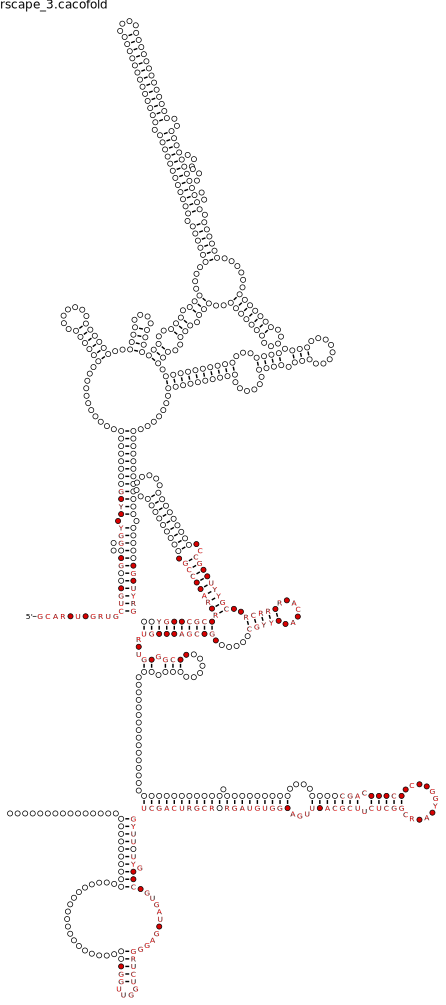

In [196]:
display_structure('NQ428_RS03930')

In [142]:
NQ428_RS06720  NQ428_RS01255

SyntaxError: invalid syntax (Temp/ipykernel_8912/2839845799.py, line 1)

'GCF_000195955.2_ASM19595v2_genomic.gbff'

In [45]:
species = 'NZ_CP102342.1'
reference_list = []
for genome_record in SeqIO.parse(seq_dir + '/' + filename_dict[species], "genbank"):
        	accession_ver = genome_record.annotations['accessions'][0] + '.' + str(genome_record.annotations['sequence_version'])
        	reference_list.append([accession_ver, str(genome_record.seq)])
util.produce_fasta_file(reference_list, project_dir+'/'+'M.smegmatis_sequence.faa')

100%|██████████| 1/1 [00:00<00:00, 18.80it/s]


In [121]:
filename_dict[ 'NZ_CP102342.1']
                  

'GCF_024600175.1_ASM2460017v1_genomic.gbff'

In [150]:
names_dict['NZ_AP022619.1']

'Mycobacterium paraseoulense'

In [186]:
screen_dir = project_dir + '/R_Scape_Results_Smegmatis'
#screen_dir = project_dir + '/R_Scape_Initial_Screen_V2'
seed_species = 'NZ_CP102342.1'
#seed_species = 'NC_000962.3' 
tb_species = 'NC_000962.3' 
#tb_species = 'NZ_CP102342.1'
screen_filename = filename_dict[seed_species]
genome_record = next(SeqIO.parse(seq_dir + '/' + screen_filename, "genbank"))
product_dict = {}
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None and a.get("product")!=None:
            product_dict[a.get("locus_tag")[0]] = a.get("product")[0]

ref_position_dict = {}
for feature in genome_record.features:
    if not(feature.type == 'gene'):
        a = feature.qualifiers
        if a.get("locus_tag")!= None:
            ref_position_dict[a.get("locus_tag")[0]] = (int(feature.location.start),int(feature.location.end),int(feature.location.strand))

seq_ids = util.list_dirs(screen_dir)
for id in seq_ids:
    species_list = []
    if os.path.exists(screen_dir + '/' + str(id) + '/hsummary_3.txt'):
        with open(screen_dir + '/' + str(id) + '/hsummary_3.txt', 'r') as f:  
            num_sig = 0
            for l in f:
                if (not ('#' in l)):
                    a = l.split()
                    if float(a[12]) < 1e-10:
                        num_sig +=1
        if num_sig > 30:
            with open(screen_dir + '/' + str(id) + '/hsummary_3.txt', 'r') as g:  
                tb_loc = 'None'
                ref_loc = 'None'
                tb_eval = 999
                ref_eval= 999
                for l in g:
                    if len(l) > 1 and (not ('#' in l)):
                        species_list.append(l.split()[0])
                        if tb_species in l:
                            temp_tb_loc = (l.split()[0].split('/')[1:])
                            e_val =  float(l.split()[12]) 
                            if  e_val < tb_eval:
                                tb_loc = temp_tb_loc
                                tb_eval = e_val
                        if seed_species in l:
                            temp_ref_loc = (l.split()[0].split('/')[1:])
                            e_val =  float(l.split()[12]) 
                            if  e_val < ref_eval:
                                ref_loc = temp_ref_loc
                                ref_eval = e_val
                num_species = len(set(species_list))
                if os.path.exists(screen_dir + '/' + str(id) + '/rscape_3.cacofold.R2R.sto.svg'):
                    structure_plotted = True
                print(id, product_dict[id], num_sig, num_species, ref_loc, tb_loc, structure_plotted)
 
                    

NQ428_RS00025 DNA topoisomerase (ATP-hydrolyzing) subunit B 102 122 ['4590-6618'] ['5239-7267'] True
NQ428_RS00045 tRNA-Ala 57 95 ['10293-10365'] None True
NQ428_RS00120 PH domain-containing protein 89 89 ['45851-46260'] ['13154-13557'] True
NQ428_RS00165 FHA domain-containing protein 85 101 ['55824-56292'] ['23269-23737'] True
NQ428_RS00170 DUF3662 domain-containing protein 95 109 ['56427-57873'] ['24709-25427'] True
NQ428_RS00175 tRNA-Leu 95 107 ['58143-58225'] ['25644-25726'] True
NQ428_RS00245 WhiB family transcriptional regulator 60 65 ['70232-70526'] ['4338198-4338440'] True
NQ428_RS00250 helix-turn-helix domain-containing protein 39 42 ['70909-71689'] None True
NQ428_RS00315 WXG100 family type VII secretion target 52 58 ['86995-87298'] ['4352273-4352575'] True
NQ428_RS00345 hypothetical protein 52 64 ['94606-95338'] ['4357631-4358315'] True
NQ428_RS00350 IS1634-like element IS1549 family transposase 235 260 ['2890665-2892132'] None True
NQ428_RS00360 IS1634-like element IS1549 f

In [192]:
[x for x in gene_info_dict[reference_species] if x[0] == 'NQ428_RS12295']

[('NQ428_RS12295',
  2609755,
  2610589,
  ('NQ428_RS12295', 1),
  ('NQ428_RS12295', 1),
  ('30S ribosomal protein S2', '30S ribosomal protein S2'))]